# DPSVC example script
Shows how to run the code and plots comparitive predictive probabilities between
- sklearn SVC and sklearn SVC with precomputed kernel
- sklearn SVC with approximate kernel
- sklearn SVC with DP


In [1]:
import os
import sys
import pylab as plt
import numpy as np
import logging
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("")))
sys.path.append(ROOT_DIR)
logging.basicConfig()
logger = logging.getLogger("wrapper_svm")
logger.setLevel(logging.INFO)
# ROOT_PROJECT_FOLDER = os.path.dirname(os.path.dirname(__file__))
# sys.path.append(ROOT_PROJECT_FOLDER)
from safemodel.classifiers import SafeSVC

# Generate data

In [2]:
def logistic(x):
    """Logistic function"""
    return 1.0 / (1.0 + np.exp(-x))


# %% Generate data

n_data = 100  # number of samples
n_features = 3  # number of features


# X,y are training data; X1, y1 are test data
coef = np.random.normal(0, 1, n_features)
X = np.random.normal(0, 1, (n_data, n_features))
X1 = np.random.normal(0, 1, (n_data, n_features))
y = np.random.binomial(1, logistic(np.matmul(X, coef)), n_data).flatten()
y1 = np.random.binomial(1, logistic(np.matmul(X1, coef)), n_data).flatten()


# %% Set parameters

gamma = 0.1  # Kernel width
C = 1  # Penalty term
dhat = 5  # Dimension of approximator
eps = 500  # DP level (not very private)

In [3]:
# Kernel for approximator: equivalent to rbf.
def rbf(x, y, gamma=1):
    return np.exp(-gamma * np.sum((x - y) ** 2))


def rbf_svm(x, y, gamma=1):
    r = np.zeros((x.shape[0], y.shape[0]))
    for i in range(x.shape[0]):
        for j in range(y.shape[0]):
            r[i, j] = rbf(x[i, :], y[j, :], gamma)
    return r

In [4]:
# %% Basic SVM fitted using RBF
clf0 = SVC(probability=True, kernel="rbf", gamma=gamma, C=C)
clf0.fit(X, y)
c0 = clf0.predict(X1)
p0 = clf0.predict_proba(X1)

In [5]:
# %% SVM fitted using approximate finite-dimensional RBF kernel
clf1 = SVC(probability=True, kernel="precomputed", C=C)
gram_matrix = rbf_svm(X, X, gamma=gamma)
clf1.fit(gram_matrix, y)
test_gram = rbf_svm(X1, X, gamma=gamma)
c1 = clf1.predict(test_gram)
p1 = clf1.predict_proba(test_gram)

In [6]:
# %% DP version with no DP level (predicted labels equivalent to clf1;
# predicted probabilities will not be)
clf2 = SafeSVC(eps=-1, dhat=dhat, gamma=gamma)
clf2.fit(X, y)
c2 = clf2.predict(X1)
p2 = clf2.predict_proba(X1)

In [7]:
# %% DP version with DP level (approximate)
clf3 = SafeSVC(eps=eps, dhat=dhat, C=C, gamma=gamma)
clf3.fit(X, y)
c3 = clf3.predict(X1)
p3 = clf3.predict_proba(X1)

In [8]:
# %% Print predictions
# First two columns should match exactly, third should be similar and fourth
# will vary depending on eps, N and C
pred_zip = zip(c0, c1, c2, c3)
for a, b, c, d in pred_zip:
    logger.info("%s %s %s %s", a, b, c, d)
    # print(a, b,c, d)

INFO:wrapper_svm:0 0 1 1
INFO:wrapper_svm:0 0 1 1
INFO:wrapper_svm:0 0 1 1
INFO:wrapper_svm:1 1 1 1
INFO:wrapper_svm:0 0 1 1
INFO:wrapper_svm:0 0 1 0
INFO:wrapper_svm:1 1 1 1
INFO:wrapper_svm:1 1 1 1
INFO:wrapper_svm:1 1 1 1
INFO:wrapper_svm:1 1 1 1
INFO:wrapper_svm:0 0 1 1
INFO:wrapper_svm:1 1 1 1
INFO:wrapper_svm:1 1 1 1
INFO:wrapper_svm:0 0 1 0
INFO:wrapper_svm:1 1 1 1
INFO:wrapper_svm:1 1 0 1
INFO:wrapper_svm:0 0 1 1
INFO:wrapper_svm:1 1 1 1
INFO:wrapper_svm:0 0 1 0
INFO:wrapper_svm:0 0 1 1
INFO:wrapper_svm:1 1 1 0
INFO:wrapper_svm:1 1 1 1
INFO:wrapper_svm:0 0 1 1
INFO:wrapper_svm:0 0 1 1
INFO:wrapper_svm:1 1 0 1
INFO:wrapper_svm:1 1 1 1
INFO:wrapper_svm:0 0 1 1
INFO:wrapper_svm:0 0 1 1
INFO:wrapper_svm:0 0 0 0
INFO:wrapper_svm:1 1 1 1
INFO:wrapper_svm:1 1 0 1
INFO:wrapper_svm:1 1 1 1
INFO:wrapper_svm:1 1 1 1
INFO:wrapper_svm:1 1 1 0
INFO:wrapper_svm:0 0 1 1
INFO:wrapper_svm:0 0 1 1
INFO:wrapper_svm:0 0 1 1
INFO:wrapper_svm:1 1 1 1
INFO:wrapper_svm:1 1 1 1
INFO:wrapper_svm:0 0 1 1


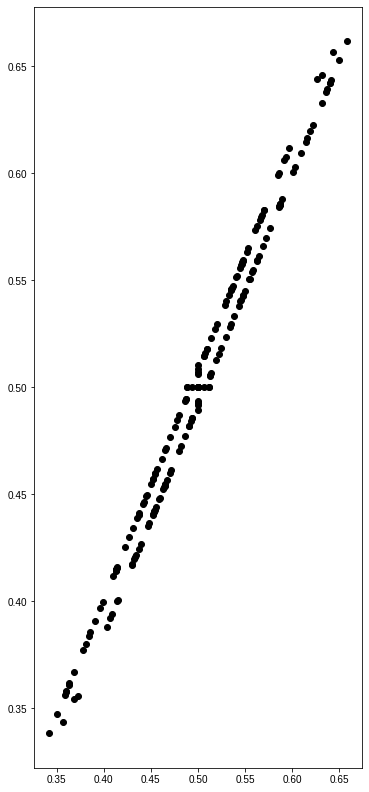

In [9]:
# %% plot p0 vs p1: finite-dimensional approximator works OK
plt.figure(figsize=(20, 14))
plt.subplot(1, 3, 1)
plt.style.use("seaborn-whitegrid")
plt.plot(p0, p1, "o", color="black")

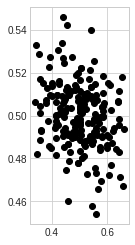

In [10]:
# Plot p1 vs p2: logistic-regression based predict_proba is roughly equivalent to Platt
# scaling, at least here
plt.subplot(1, 3, 2)
plt.style.use("seaborn-whitegrid")
plt.plot(p1, p2, "o", color="black")

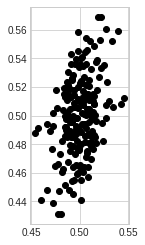

In [11]:
# Plot p2 vs p3: enforcing differential privacy means we don't match very well.
# Set higher DP level,
# higher N, or lower C to match better.
plt.subplot(1, 3, 3)
plt.style.use("seaborn-whitegrid")
plt.plot(p2, p3, "o", color="black")

In [12]:
clf2.save(name="testSaveSVC.pkl")
clf2.preliminary_check()
clf2.request_release("testSaveSVC.pkl")

DEBUG:/home/andy/GRAIMatter/safemodel/safemodel.py:copying model_type
DEBUG:/home/andy/GRAIMatter/safemodel/safemodel.py:...done
DEBUG:/home/andy/GRAIMatter/safemodel/safemodel.py:copying model
DEBUG:/home/andy/GRAIMatter/safemodel/safemodel.py:...done
DEBUG:/home/andy/GRAIMatter/safemodel/safemodel.py:copying saved_model
DEBUG:/home/andy/GRAIMatter/safemodel/safemodel.py:...done
DEBUG:/home/andy/GRAIMatter/safemodel/safemodel.py:copying model_save_file
DEBUG:/home/andy/GRAIMatter/safemodel/safemodel.py:...done
DEBUG:/home/andy/GRAIMatter/safemodel/safemodel.py:copying ignore_items
DEBUG:/home/andy/GRAIMatter/safemodel/safemodel.py:...done
DEBUG:/home/andy/GRAIMatter/safemodel/safemodel.py:copying examine_seperately_items
DEBUG:/home/andy/GRAIMatter/safemodel/safemodel.py:...done
DEBUG:/home/andy/GRAIMatter/safemodel/safemodel.py:copying filename
DEBUG:/home/andy/GRAIMatter/safemodel/safemodel.py:...done
DEBUG:/home/andy/GRAIMatter/safemodel/safemodel.py:copying researcher
DEBUG:/home/

Model parameters are within recommended ranges.



In [13]:
# X,y are training data; X1, y1 are test data
coef = np.random.normal(0, 1, n_features)
X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
X1 = np.array([[7, 8, 9], [4, 5, 6]])
y = np.array([0, 1, 0])


# %% Set parameters

gamma = 0.1  # Kernel width
C = 1  # Penalty term
dhat = 5  # Dimension of approximator
eps = 500  # DP level (not very private)

# %% DP version with DP level (approximate)

clf3 = SafeSVC(eps=eps, dhat=dhat, C=C, gamma=gamma)
clf3.fit(X, y)
clf3.save(name="testSaveSVC.pkl")